In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import zipfile
import os

zip_path = '/content/drive/MyDrive/Palm_IMAGE.zip'
extract_path = '/content/Hands and palm images dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset unzipped successfully to: {extract_path}")


Dataset unzipped successfully to: /content/Hands and palm images dataset


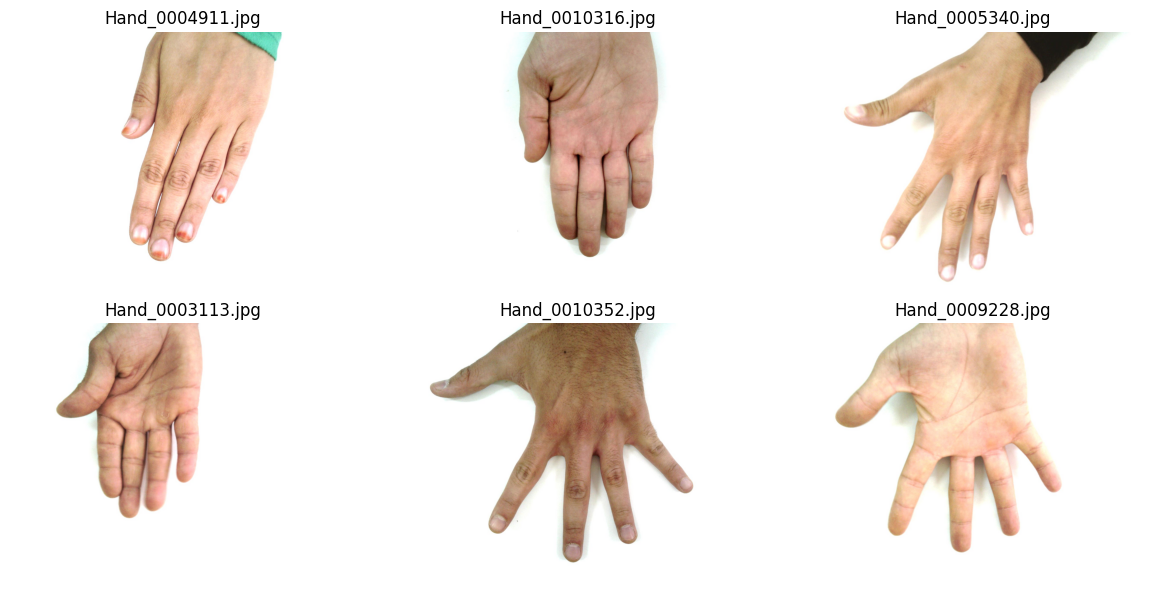

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = '/content/Hands and palm images dataset/Hands/Hands'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print(f"No image files found in {image_dir}")
else:
    plt.figure(figsize=(12, 6))
    for i in range(min(6, len(image_files))):
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

csv_path = os.path.join(image_dir, '/content/Hands and palm images dataset/HandInfo.csv')  # adjust filename if needed
df = pd.read_csv(csv_path)

print("First few rows of the label data:")
print(df.head())

print("\nColumns available:")
print(df.columns)

print("\nMissing values:")
print(df.isnull().sum())


First few rows of the label data:
   id  age gender skinColor  accessories  nailPolish  aspectOfHand  \
0   0   27   male      fair            0           0  dorsal right   
1   0   27   male      fair            0           0  dorsal right   
2   0   27   male      fair            0           0  dorsal right   
3   0   27   male      fair            0           0  dorsal right   
4   0   27   male      fair            0           0  dorsal right   

          imageName  irregularities  
0  Hand_0000002.jpg               0  
1  Hand_0000003.jpg               0  
2  Hand_0000004.jpg               0  
3  Hand_0000005.jpg               0  
4  Hand_0000006.jpg               0  

Columns available:
Index(['id', 'age', 'gender', 'skinColor', 'accessories', 'nailPolish',
       'aspectOfHand', 'imageName', 'irregularities'],
      dtype='object')

Missing values:
id                0
age               0
gender            0
skinColor         0
accessories       0
nailPolish        0
aspectOfHan

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

df_filtered = df[['imageName', 'gender', 'age']]

le_gender = LabelEncoder()
df_filtered['gender_encoded'] = le_gender.fit_transform(df_filtered['gender'])

image_data = []
gender_labels = []
age_labels = []

img_size = (128, 128)

for i, row in df_filtered.iterrows():
    img_path = os.path.join(image_dir, row['imageName'])

    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(img_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        image_data.append(img_array)

        gender_labels.append(row['gender_encoded'])
        age_labels.append(row['age'])

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

X = np.array(image_data)
y_gender = to_categorical(np.array(gender_labels), num_classes=2)  # Binary classification
y_age = np.array(age_labels)

X_train, X_test, y_gender_train, y_gender_test = train_test_split(
    X, y_gender, test_size=0.2, random_state=42
)

print(f"Total images: {len(X)}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


<ipython-input-5-a30c0ad403c4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['gender_encoded'] = le_gender.fit_transform(df_filtered['gender'])


Total images: 11076
Train shape: (8860, 128, 128, 3), Test shape: (2216, 128, 128, 3)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


df = pd.read_csv("/content/Hands and palm images dataset/HandInfo.csv")  # replace with your actual CSV path
le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])  # 0: female, 1: male
y_gender = to_categorical(df['gender_encoded'])

X_train, X_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, random_state=42, stratify=y_gender)

y_labels = np.argmax(y_train_gender, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(weights))

def build_base_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
    ])
    return model

base_model = build_base_cnn()
model_gender = models.Sequential([
    base_model,
    layers.Dense(2, activation='softmax')
])

model_gender.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_gender.summary()

history_gender = model_gender.fit(
    X_train, y_train_gender,
    epochs=10,
    validation_data=(X_test, y_test_gender),
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │     3,304,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.6773 - loss: 0.6116 - val_accuracy: 0.8430 - val_loss: 0.3644
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8556 - loss: 0.3352 - val_accuracy: 0.8854 - val_loss: 0.2645
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9105 - loss: 0.2124 - val_accuracy: 0.8917 - val_loss: 0.2437
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9377 - loss: 0.1513 - val_accuracy: 0.9598 - val_loss: 0.1017
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9622 - loss: 0.0987 - val_accuracy: 0.9725 - val_loss: 0.0797
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9733 - loss: 0.0792 - val_accuracy: 0.9869 - val_loss: 0.0442
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9844 - loss: 0.0443 - val_accuracy: 0.9765 - val_loss: 0.0740
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9863 - loss: 0.0339 - val

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

      Female       0.99      0.99      0.99      1422
        Male       0.98      0.98      0.98       794

    accuracy                           0.98      2216
   macro avg       0.98      0.98      0.98      2216
weighted avg       0.98      0.98      0.98      2216



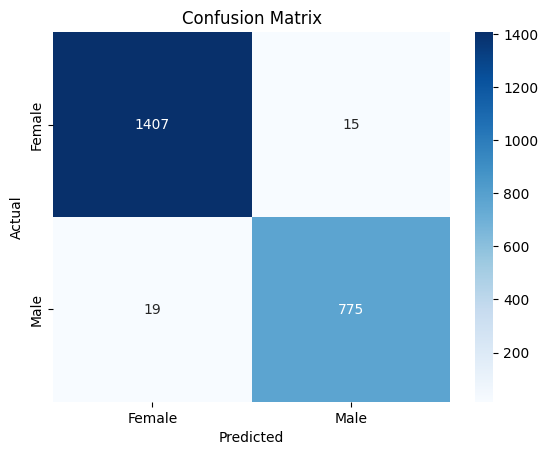

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model_gender.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_gender, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=['Female', 'Male']))

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


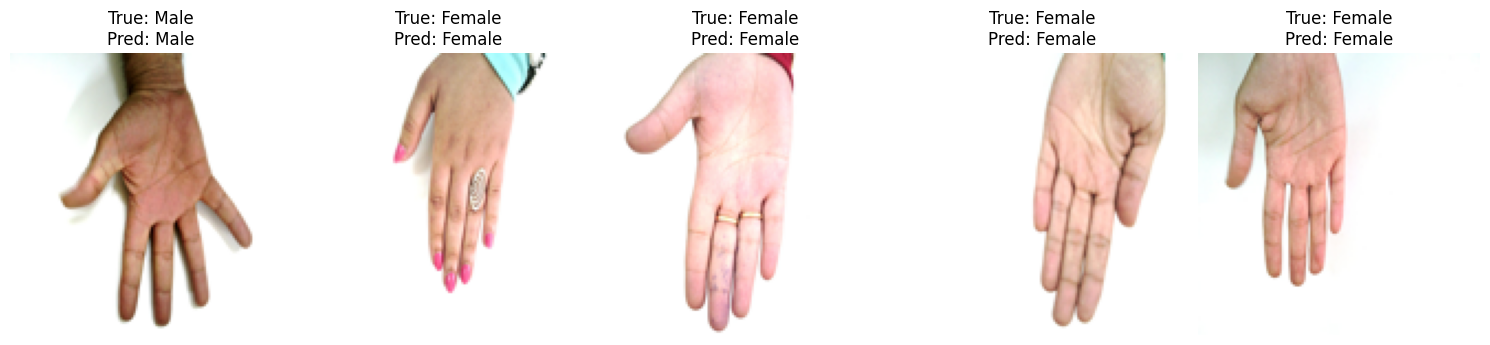

In [ ]:
import random

labels = ['Female', 'Male']

plt.figure(figsize=(15, 5))
for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = labels[y_true_classes[idx]]
    pred_label = labels[y_pred_classes[idx]]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()


In [ ]:

def age_bucket(age):
    if age <= 12:
        return 'Child'
    elif age <= 19:
        return 'Teen'
    elif age <= 35:
        return 'YoungAdult'
    elif age <= 55:
        return 'Adult'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(age_bucket)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le_age = LabelEncoder()
df['age_group_encoded'] = le_age.fit_transform(df['age_group'])  # e.g. 0 = Child, 1 = Teen, ...

y_age_class = to_categorical(df['age_group_encoded'])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_age, y_test_age = train_test_split(
    X, y_age_class, test_size=0.2, random_state=42, stratify=y_age_class
)


In [ ]:
def build_age_classification_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(le_age.classes_), activation='softmax')  # num of age buckets
    ])
    return model

model_age_class = build_age_classification_cnn()
model_age_class.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

model_age_class.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_age_class = model_age_class.fit(
    X_train, y_train_age,
    epochs=10,
    validation_data=(X_test, y_test_age)
)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9422 - loss: 0.2290 - val_accuracy: 0.9761 - val_loss: 0.1153
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9741 - loss: 0.1077 - val_accuracy: 0.9833 - val_loss: 0.0768
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9806 - loss: 0.0774 - val_accuracy: 0.9819 - val_loss: 0.0682
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9838 - loss: 0.0675 - val_accuracy: 0.9792 - val_loss: 0.0766
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9871 - loss: 0.0467 - val_accuracy: 0.9851 - val_loss: 0.0496
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9891 - loss: 0.0360 - val_accuracy: 0.9869 - val_loss: 0.0535
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9933 - loss: 0.0195 - val_accuracy: 0.9941 - val_loss: 0.0172
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9965 - loss: 0.0128 - val_

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

       Adult       1.00      0.72      0.84        25
      Senior       1.00      1.00      1.00        34
        Teen       0.96      0.92      0.94        25
  YoungAdult       1.00      1.00      1.00      2132

    accuracy                           1.00      2216
   macro avg       0.99      0.91      0.94      2216
weighted avg       1.00      1.00      1.00      2216



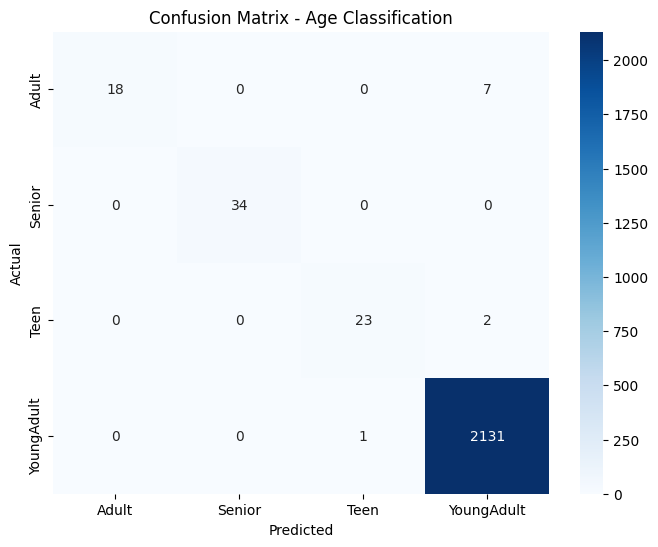

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_age_probs = model_age_class.predict(X_test)
y_pred_age_classes = np.argmax(y_pred_age_probs, axis=1)
y_true_age_classes = np.argmax(y_test_age, axis=1)

print(classification_report(y_true_age_classes, y_pred_age_classes, target_names=le_age.classes_))

cm = confusion_matrix(y_true_age_classes, y_pred_age_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_age.classes_, yticklabels=le_age.classes_)
plt.title('Confusion Matrix - Age Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


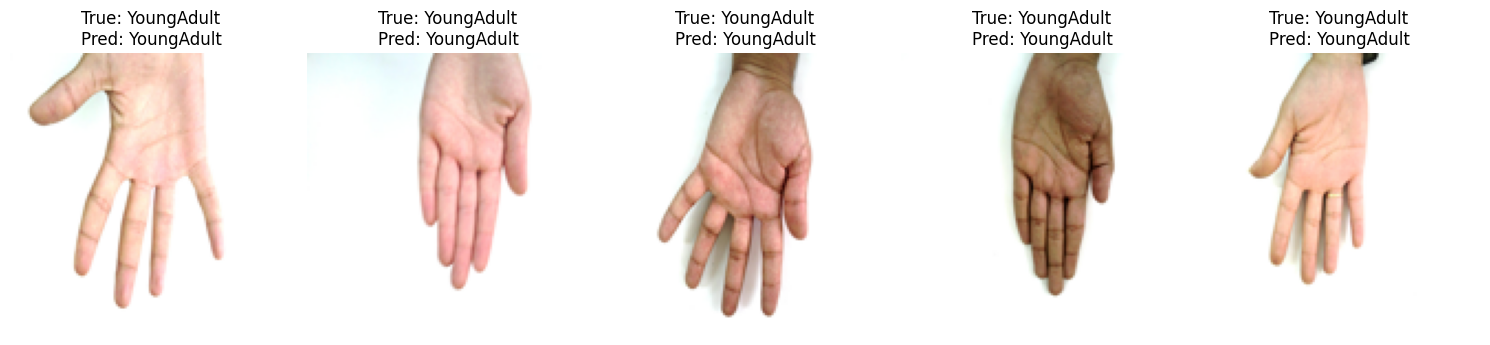

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]

    true_age_group_index = np.argmax(y_test_age[idx])
    pred_age_group_index = np.argmax(model_age_class.predict(np.expand_dims(img, axis=0))) # Predict and get index

    true_age_group = le_age.classes_[true_age_group_index]
    pred_age_group = le_age.classes_[pred_age_group_index]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_age_group}\nPred: {pred_age_group}")

plt.tight_layout()
plt.show()

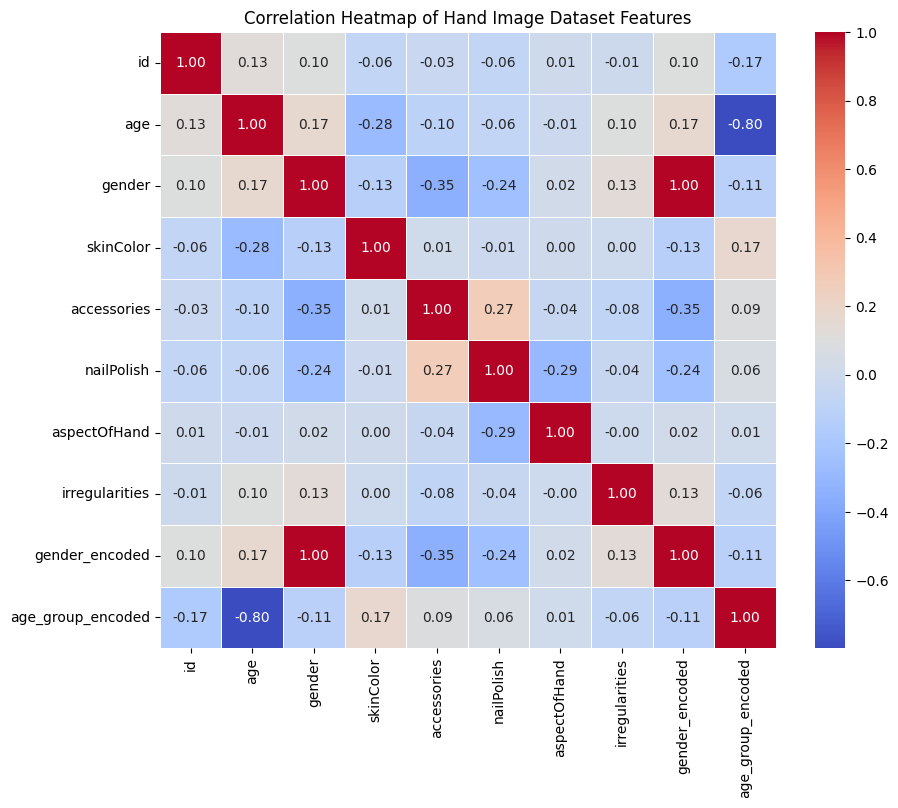

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

categorical_cols = ['gender', 'skinColor', 'aspectOfHand', 'accessories', 'nailPolish', 'irregularities']
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

df_encoded = df_encoded.drop(['imageName', 'age_group'], axis=1, errors='ignore')

corr_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Hand Image Dataset Features")
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image
import scipy.stats as stats
import matplotlib.pyplot as plt

image_folder = '/content/Hands and palm images dataset/Hands/Hands'
image_files = os.listdir(image_folder)

mean_intensities = []

for image_file in image_files:
    img = Image.open(os.path.join(image_folder, image_file))
    img = img.convert('L')
    np_img = np.array(img)
    mean_intensities.append(np.mean(np_img))

mean_intensities = np.array(mean_intensities)

population_mean = 128
population_std_dev = 50
alpha = 0.05

# Z-test
z_score = (np.mean(mean_intensities) - population_mean) / (population_std_dev / np.sqrt(len(mean_intensities)))
p_value_z = 2 * (1 - stats.norm.cdf(abs(z_score)))

# T-test
t_statistic, p_value_t = stats.ttest_1samp(mean_intensities, population_mean)

# ANOVA
group1 = mean_intensities[:len(mean_intensities)//2]
group2 = mean_intensities[len(mean_intensities)//2:]
f_statistic, p_value_anova = stats.f_oneway(group1, group2)

# Output
print(f"Z-test: Z-score = {z_score:.4f}, p-value = {p_value_z:.4f}")
print("Null hypothesis is", "rejected" if p_value_z < alpha else "accepted")

print(f"T-test: T-statistic = {t_statistic:.4f}, p-value = {p_value_t:.4f}")
print("Null hypothesis is", "rejected" if p_value_t < alpha else "accepted")

print(f"ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value_anova:.4f}")
print("Null hypothesis is", "rejected" if p_value_anova < alpha else "accepted")


Z-test: Z-score = 219.1524, p-value = 0.0000
Null hypothesis is rejected
T-test: T-statistic = 1327.1534, p-value = 0.0000
Null hypothesis is rejected
ANOVA: F-statistic = 2.1485, p-value = 0.1427
Null hypothesis is accepted
